# Evaluating semantic segmentations

> Written by Dr Daniel Buscombe, Northern Arizona University

> Part of a series of notebooks for image recognition and classification using deep convolutional neural networks

Standard metrics of precision, P, recall, R, accuracy, A, and F1 score, F, are used to assess classification of image regions and pixels. 

Where TP, TN, FP, and FN are, respectively, the frequencies of true positives, true negatives, false positives, and false negatives: 

$P=  \frac{TP}{(TP+FP)}$

$R=  \frac{TP}{(TP+FN)}$

$A=  \frac{(TP+TN)}{(TP+TN+FP+FN)}$

$F=2\times \frac{(P \times R)}{(P+R)}$


True positives are image regions/pixels correctly classified as belonging to a certain class by the model, while true negatives are correctly classified as not belonging to a certain class. 

False negatives are regions/pixels incorrectly classified as not belonging to a certain class, and false positives are those regions/pixels incorrectly classified as belonging to a certain class. 

Precision and recall are useful where the number of observations belonging to one class is significantly lower than those belonging to the other classes. 

Recall is a measure of the ability to detect the occurrence of a class, which is a given landform, land use or land cover.
 
These metrics are therefore used in evaluation of pixelwise segmentations, where the number of pixels corresponding to each class vary considerably. 

The F1 score is an equal weighting of the recall and precision and quantifies how well the model performs in general.

hi


In [49]:

import os, time
from glob import glob
from imageio import imread
import itertools

#numerical
import tensorflow as tf
import numpy as np

#plots
import matplotlib.pyplot as plt

#supress tf warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import warnings
warnings.filterwarnings("ignore")

# suppress divide and invalid warnings
np.seterr(divide='ignore')
np.seterr(invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [50]:
# =========================================================
def load_graph(model_file):
    graph = tf.Graph()
    graph_def = tf.GraphDef()

    with open(model_file, "rb") as f:
        graph_def.ParseFromString(f.read())
    with graph.as_default():
        tf.import_graph_def(graph_def)

    return graph

# =========================================================
def getCP(tmp, graph):  
    #graph = load_graph(classifier_file)

    input_name = "import/Placeholder" ##+ input_layer
    output_name = "import/final_result" ##+ output_layer
    input_operation = graph.get_operation_by_name(input_name);
    output_operation = graph.get_operation_by_name(output_name);

    with tf.Session(graph=graph) as sess:
        results = sess.run(output_operation.outputs[0],
                      {input_operation.outputs[0]: np.expand_dims(tmp, axis=0)})
    results = np.squeeze(results)

    # Sort to show labels of first prediction in order of confidence
    top_k = results.argsort()[-len(results):][::-1]

    return top_k[0], results[top_k[0]], results[top_k] #, np.std(tmp[:,:,0])


# =========================================================
def norm_im(image_path):
    input_mean = 0 #128
    input_std = 255 #128

    input_name = "file_reader"
    output_name = "normalized"
    img = imread(image_path)
    nx, ny, nz = np.shape(img)

    theta = np.std(img).astype('int')

    file_reader = tf.read_file(image_path, input_name)
    image_reader = tf.image.decode_jpeg(file_reader, channels = 3,
                                        name='jpeg_reader')
    float_caster = tf.cast(image_reader, tf.float32)

    dims_expander = tf.expand_dims(float_caster, 0);
    normalized = tf.divide(tf.subtract(dims_expander, [input_mean]), [input_std])
    sess = tf.Session()
    return np.squeeze(sess.run(normalized))
      

In [51]:
def eval_tiles(label, direc, numero, classifier_file, x, n):
    #for label in labels:
    graph = load_graph(classifier_file)

    print(label)
    infiles = glob(direc+os.sep+label+os.sep+'*.jpg')[:numero]

    Z = []
    for image_path in infiles:
        Z.append(norm_im(image_path))

    w1 = []
    for i in range(len(Z)):
        w1.append(getCP(Z[i], graph))

    C, P, _ = zip(*w1) ##,S
    del w1, Z

    C = np.asarray(C)
    P = np.asarray(P)

    e = precision_recall_fscore_support(np.ones(len(C))*x, C)

    cm = np.zeros((n,n))
    for a, p in zip(np.ones(len(C), dtype='int')*x, C):
        cm[a][p] += 1

    cm = cm[x,:]

    p = np.max(e[0])
    r = np.max(e[1])
    f = np.max(e[2])
    a = np.sum([c==x for c in C])/len(C)
    #print(label+' accuracy %f' % (a))
    #print('precision %f' % (p) )
    #print('recall %f' % (r) )
    #print('f score %f' % (f) )
    #print('mean prob. %f' % (np.mean(P)) )
    return [a,p,r,f, np.mean(P)], cm ##C,P

In [52]:
class_file = 'labels.txt'
classifier_file = 'monterey_mobilenetv2_96_1000_0.01.pb'

## number of tiles to evaluate
numero = 10

In [53]:
## Loads label file, strips off carriage return
labels = [line.rstrip() for line 
             in tf.gfile.GFile(class_file)]
code= {}
for label in labels:
    code[label] = [i for i, x in enumerate([x.startswith(label) for x in labels]) if x].pop()

In [54]:
code

{'beach': 0, 'buildings': 1, 'cliff': 2, 'road': 3, 'sky': 4}

In [55]:
direc = 'train/tile_96'

In [56]:
w=[]
for label in labels:
    w.append(eval_tiles(label, direc, numero, classifier_file, code[label], len(labels)))

beach
buildings
cliff
road
sky


In [57]:
E, CM = zip(*w)

In [58]:
CM

(array([0., 1., 7., 2., 0.]),
 array([0., 8., 1., 1., 0.]),
 array([ 0.,  0.,  0.,  0., 10.]),
 array([2., 1., 4., 1., 2.]),
 array([5., 1., 1., 0., 3.]))

In [59]:
a=np.asarray(E)[:,0] 
f= np.asarray(E)[:,3] 
pr= np.asarray(E)[:,4] 

print('mean accuracy. %f' % (np.mean(a)) )
print('mean Fscore. %f' % (np.mean(f)) )
print('mean prob. %f' % (np.mean(pr)) )

mean accuracy. 0.240000
mean Fscore. 0.306449
mean prob. 0.770479


## Confusion matrix

A ‘confusion matrix’, which is the matrix of normalized correspondences between true and estimated labels, is a convenient way to visualize model skill. 

A perfect correspondence between true and estimated labels is scored 1.0 along the diagonal elements of the matrix.

Misclassiﬁcations are readily identiﬁed as off-diagonal elements. Systematic misclassiﬁcations are recognized as off-diagonal elements with large magnitudes. 

In [30]:
## =========================================================
def plot_confusion_matrix2(cm, classes, normalize=False, cmap=plt.cm.Blues, dolabels=True):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm[np.isnan(cm)] = 0

    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmax=1, vmin=0)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    if dolabels==True:
       tick_marks = np.arange(len(classes))
       plt.xticks(tick_marks, classes, fontsize=3) # rotation=45
       plt.yticks(tick_marks, classes, fontsize=3)

       #plt.ylabel('True label',fontsize=6)
       #plt.xlabel('Estimated label',fontsize=6)

    else:
       plt.axis('off')

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if cm[i, j]>0:
           plt.text(j, i, format(cm[i, j], fmt),
                 fontsize=3,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()

    return cm

array([[0. , 0.1, 0.7, 0.2, 0. ],
       [0. , 0.8, 0.1, 0.1, 0. ],
       [0. , 0. , 0. , 0. , 1. ],
       [0.2, 0.1, 0.4, 0.1, 0.2],
       [0.4, 0.1, 0.1, 0. , 0.4]])

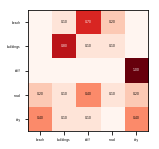

In [48]:
CM = np.asarray(CM)

fig = plt.figure()
ax1 = fig.add_subplot(221)
plot_confusion_matrix2(CM, classes=labels, normalize=True, cmap=plt.cm.Reds)